In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
full_training_inputs = np.array([[-1.2, -37]
                                 , [1.,1.]
                                 , [2., 1.]
                                 , [4, 1]
                                 , [1.,2.]
                                 , [4, 6]                                 
                              ])
#print(full_training_inputs)
full_training_outputs = np.array([[2.1
                                   , -0.5
                                   , 10
                                   , 3.2
                                   , 22
                                   , 10                                   
                                ]])
print(full_training_outputs)

[[ 2.1 -0.5 10.   3.2 22.  10. ]]


In [3]:
class NNet_init(tf.keras.Model):
  def __init__(self):
    super(NNet_init, self).__init__()
    self.weights_var = tf.Variable([[1.,  0.9]
                                    ], name = "weights_var")
    self.bias_var = tf.Variable([[1.]
                                 ], name = "bias_var")
    self.weights_out_var = tf.Variable([[1.
                                         ]], name = "weights_out_var")
    
    
    
  def call(self, input_data):
    input_data = tf.transpose(input_data)
    layer_1_var = tf.linalg.matmul(self.weights_var, input_data) + self.bias_var
    layer_1_var_activated = tf.nn.leaky_relu(layer_1_var)
    layer_out_var = tf.linalg.matmul(self.weights_out_var, layer_1_var_activated)
    
    return layer_out_var

In [4]:
training_inputs = tf.constant(full_training_inputs[0,:].reshape((1,2))
                             , dtype = "float32")
print(training_inputs)
training_outputs = tf.constant(full_training_outputs[0,0].reshape((1,1))
                              , dtype = "float32")
print(training_outputs)

tf.Tensor([[ -1.2 -37. ]], shape=(1, 2), dtype=float32)
tf.Tensor([[2.1]], shape=(1, 1), dtype=float32)


In [5]:
# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.weights_var
                                    , model.bias_var
                                    , model.weights_out_var
                                    ])

In [6]:
model = NNet_init()

In [7]:
optimizer = (tf.keras.optimizers.Adam()
            )

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Initial loss: 77.440


In [8]:
grads = grad(model, training_inputs, training_outputs)
for i in range(len(grads)):
    print(grads[i])

tf.Tensor([[  4.2240005 130.24     ]], shape=(1, 2), dtype=float32)
tf.Tensor([[-3.5200002]], shape=(1, 1), dtype=float32)
tf.Tensor([[117.920006]], shape=(1, 1), dtype=float32)


In [9]:
optimizer.apply_gradients(zip(grads, [model.weights_var, 
    model.bias_var
                                    , model.weights_out_var
                                     ]))
best_loss = loss(model, training_inputs, training_outputs).numpy()
best_iter = -1
best_loss

77.18445

In [10]:
j = 0
while best_loss > 0.0 and j < 10:
  for i in range(80000):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.weights_var,
      model.bias_var
                                    , model.weights_out_var
                                       ]))
    current_loss = loss(model, training_inputs, training_outputs).numpy()
    if current_loss < best_loss:
      best_loss = current_loss
      best_iter = i
    if i % 8000 == 0:
      print("Loss at step {}, {:03d}: {:5f}".format(j, i, loss(model, training_inputs, training_outputs)))
    if i - best_iter > 2000:
      break
  j += 1

Loss at step 0, 000: 76.929604


In [11]:
print("Halted at step: {} with loss {:.3f}, W = {}, B = {}, W_out = {}".format(i,
                                                                               current_loss
                                                                               , model.weights_var.numpy()
                                                                               , model.bias_var.numpy()
                                                                               , model.weights_out_var.numpy())
     )

Halted at step: 6671 with loss 0.000, W = [[ 0.00293999 -0.09705605]], B = [[1.9970503]], W_out = [[0.3760343]]


In [12]:
results_weights_var = model.weights_var.numpy()
results_bias_var = model.bias_var.numpy()
results_weights_out_var = model.weights_out_var.numpy()
print(results_weights_var)

[[ 0.00293999 -0.09705605]]


__Initialization complete__

In [13]:
class NNet(tf.keras.Model):
  def __init__(self):
    super(NNet, self).__init__()
    self.weights_const = tf.constant(results_weights_var)
    self.biases_const = tf.constant(results_bias_var)
    self.weights_out_const = tf.constant(results_weights_out_var)
    
    self.weights_var = tf.Variable(np.random.uniform(size = (1,2))
                                   , name = "weights_var"
                                   , dtype = "float32")
    self.bias_var = tf.Variable(np.random.uniform(size = (1,1))
                                , name = "bias_var"
                               , dtype = "float32")
    self.weights_out_var = tf.Variable(np.random.uniform(size = (1,1))
                                       , name = "weights_out_var"
                                      , dtype = "float32")
    
  def call(self, input_data):
    input_data = tf.transpose(input_data)
    layer_1_const = tf.linalg.matmul(self.weights_const, input_data, transpose_b = False) + self.biases_const
    layer_1_const = tf.nn.leaky_relu(layer_1_const)
    layer_out_const = tf.linalg.matmul(self.weights_out_const, layer_1_const, transpose_b = False)
    
    layer_1_var = tf.linalg.matmul(self.weights_var, input_data, transpose_b = False) + self.bias_var
    layer_1_var_activated = tf.nn.leaky_relu(layer_1_var)
    layer_out_var = tf.linalg.matmul(self.weights_out_var, layer_1_var_activated, transpose_b = False)
    #layer_out_var = self.weights_out_var * layer_1_var_activated
    
    return layer_out_const + layer_out_var


In [14]:
training_inputs = tf.constant(full_training_inputs[:2,:]
                             , dtype = "float32")
print(training_inputs)
training_outputs = tf.constant(full_training_outputs[:,:2]
                              , dtype = "float32")
print(training_outputs)

tf.Tensor(
[[ -1.2 -37. ]
 [  1.    1. ]], shape=(2, 2), dtype=float32)
tf.Tensor([[ 2.1 -0.5]], shape=(1, 2), dtype=float32)


In [15]:
model = NNet()

In [16]:
optimizer = (tf.keras.optimizers.Adam()
            )

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Initial loss: 4.159


In [17]:
grads = grad(model, training_inputs, training_outputs)
for i in range(len(grads)):
    print(grads[i])

tf.Tensor([[ 2.2186797 10.214375 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[1.7273241]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.768092]], shape=(1, 1), dtype=float32)


In [18]:
optimizer.apply_gradients(zip(grads, [model.weights_var, 
    model.bias_var
                                    , model.weights_out_var
                                     ]))
best_loss = loss(model, training_inputs, training_outputs).numpy()
best_iter = -1
best_loss

4.137771

In [19]:
j = 0
while best_loss > 0.000001 and j < 10:
  for i in range(80000):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.weights_var,
      model.bias_var
                                    , model.weights_out_var
                                       ]))
    current_loss = loss(model, training_inputs, training_outputs).numpy()
    if current_loss < best_loss:
      best_loss = current_loss
      best_iter = i
    if i % 8000 == 0:
      print("Loss at step {}, {:03d}: {:5f}".format(j, i, loss(model, training_inputs, training_outputs)))
    if i - best_iter > 2000:
      break
  j += 1

Loss at step 0, 000: 4.117011
Loss at step 0, 8000: 0.000000


In [20]:
print("Halted at step: {} with loss {:.3f}, W = {}, B = {}, W_out = {}".format(i,
                                                                               current_loss
                                                                               , model.weights_var.numpy()
                                                                               , model.bias_var.numpy()
                                                                               , model.weights_out_var.numpy())
     )

Halted at step: 14332 with loss 0.000, W = [[-1.8064003   0.01491064]], B = [[-1.615987]], W_out = [[1.7836784]]


In [21]:
results_weights_var = np.concatenate((results_weights_var
                                     , model.weights_var.numpy()
                                     )
                                    )

results_bias_var = np.concatenate((results_bias_var
                                  , model.bias_var.numpy()))

results_weights_out_var = np.concatenate((results_weights_out_var
                                          , model.weights_out_var.numpy()
                                          )
                                        , axis = 1)
print(results_weights_var)

[[ 0.00293999 -0.09705605]
 [-1.8064003   0.01491064]]


In [22]:
tmp = np.concatenate(([[4.055589]], [[4.055589]])
                     , axis = 1
                    )
#.reshape((1,2))
print(tmp)
#np.array([[1,2,3]]).shape

[[4.055589 4.055589]]


__Attempt as a loop__

In [23]:
for rows_of_data_to_fit in range(3, 1 + full_training_outputs.shape[1]):
  print("Fitting {} rows of data".format(rows_of_data_to_fit))
  number_neurons_to_fit_with = 1
  best_loss = 1
  
  while number_neurons_to_fit_with <= 10 and best_loss > 0.001:
    print("with {} neuron(s)".format(number_neurons_to_fit_with))
    class NNet(tf.keras.Model):
      def __init__(self):
        super(NNet, self).__init__()
        self.weights_const = tf.constant(results_weights_var, dtype = "float32")
        self.biases_const = tf.constant(results_bias_var, dtype = "float32")
        self.weights_out_const = tf.constant(results_weights_out_var, dtype = "float32")
    
        self.weights_var = tf.Variable(np.random.uniform(size = (number_neurons_to_fit_with, 2))
                                       , name = "weights_var"
                                       , dtype = "float32")
        self.bias_var = tf.Variable(np.random.uniform(size = (number_neurons_to_fit_with, 1))
                                    , name = "bias_var"
                                   , dtype = "float32")
        self.weights_out_var = tf.Variable(np.random.uniform(size = (1, number_neurons_to_fit_with))
                                           , name = "weights_out_var"
                                          , dtype = "float32")    
    
      def call(self, input_data):
        input_data = tf.transpose(input_data)
        layer_1_const = tf.linalg.matmul(self.weights_const, input_data) + self.biases_const
        layer_1_const = tf.nn.leaky_relu(layer_1_const)
        layer_out_const = tf.linalg.matmul(self.weights_out_const, layer_1_const, transpose_b = False)
    
        layer_1_var = tf.linalg.matmul(self.weights_var, input_data) + self.bias_var
        layer_1_var_activated = tf.nn.leaky_relu(layer_1_var)
        layer_out_var = tf.linalg.matmul(self.weights_out_var, layer_1_var_activated)
    
        return layer_out_const + layer_out_var

    training_inputs = tf.constant(full_training_inputs[:rows_of_data_to_fit,:]
                                 , dtype = "float32")
    training_outputs = tf.constant(full_training_outputs[:,:rows_of_data_to_fit]
                                  , dtype = "float32")

    model = NNet()
    optimizer = tf.keras.optimizers.Adam()

    grads = grad(model, training_inputs, training_outputs)

    optimizer.apply_gradients(zip(grads, [model.weights_var, 
        model.bias_var
                                        , model.weights_out_var
                                         ]))
    best_loss = loss(model, training_inputs, training_outputs).numpy()
    best_iter = -1

    j = 0
    while best_loss > 0.000001 and j < 4:
      for i in range(80000):
        grads = grad(model, training_inputs, training_outputs)
        optimizer.apply_gradients(zip(grads, [model.weights_var,
          model.bias_var
                                        , model.weights_out_var
                                           ]))
        current_loss = loss(model, training_inputs, training_outputs).numpy()
        if current_loss < best_loss:
          best_loss = current_loss
          best_iter = i
        if i % 8000 == 0:
          print("Loss at step {}, {:03d}: {:5f}".format(j, i, loss(model, training_inputs, training_outputs)))
        if i - best_iter > 2000:
          break
      j += 1
      best_iter = -1

    number_neurons_to_fit_with += 1    
    
  results_weights_var = np.concatenate((results_weights_var
                                       , model.weights_var.numpy()
                                       )
                                      )

  results_bias_var = np.concatenate((results_bias_var
                                    , model.bias_var.numpy()))

  results_weights_out_var = np.concatenate((results_weights_out_var
                                            , model.weights_out_var.numpy()
                                            )
                                          , axis = 1)

Fitting 3 rows of data
with 1 neuron(s)
Loss at step 0, 000: 34.047142
Loss at step 0, 8000: 0.000000
Loss at step 0, 16000: 0.000000
Fitting 4 rows of data
with 1 neuron(s)
Loss at step 0, 000: 212.954254
Loss at step 0, 8000: 2.864986
Loss at step 1, 000: 1.756455
Loss at step 2, 000: 1.756455
Loss at step 3, 000: 1.756474
with 2 neuron(s)
Loss at step 0, 000: 210.846954
Loss at step 0, 8000: 13.801014
Loss at step 1, 000: 13.801014
Loss at step 2, 000: 13.801010
Loss at step 3, 000: 13.801012
with 3 neuron(s)
Loss at step 0, 000: 339.963654
Loss at step 0, 8000: 3.595809
Loss at step 0, 16000: 0.000001
Fitting 5 rows of data
with 1 neuron(s)
Loss at step 0, 000: 120.838135
Loss at step 0, 8000: 62.609173
Loss at step 1, 000: 62.609180
Loss at step 2, 000: 62.609169
Loss at step 3, 000: 62.609180
with 2 neuron(s)
Loss at step 0, 000: 117.149513
Loss at step 0, 8000: 0.000000
Fitting 6 rows of data
with 1 neuron(s)
Loss at step 0, 000: 550.352966
Loss at step 0, 8000: 291.629395
Loss 

In [24]:
print(results_weights_var)
print(results_bias_var)
print(results_weights_out_var)

[[ 2.9399912e-03 -9.7056054e-02]
 [-1.8064003e+00  1.4910637e-02]
 [ 3.2217562e+00 -1.8651757e-01]
 [ 2.9733770e+00 -7.3177719e-01]
 [ 2.1737335e+00 -1.1891392e+00]
 [ 7.9192072e-01  2.3103638e+00]
 [-3.7493932e+00  5.0147133e+00]
 [ 1.1052321e+00 -1.4782224e+00]
 [ 3.3738452e-01 -2.4047546e+00]
 [-7.3040712e-01  4.5971361e-01]
 [ 3.0730014e+00 -1.8441094e+00]
 [ 2.0833323e+00  3.0476074e+00]
 [-6.7727047e-01  5.3606176e-01]
 [-3.1413722e+00  1.8844931e+00]]
[[ 1.9970503 ]
 [-1.615987  ]
 [-3.0352924 ]
 [-5.2151594 ]
 [-0.9846479 ]
 [-0.4650485 ]
 [-1.2654616 ]
 [ 0.37303057]
 [-1.5036277 ]
 [ 2.4619    ]
 [-1.2288816 ]
 [-1.8901116 ]
 [ 2.1730328 ]
 [ 1.2566622 ]]
[[ 0.3760343  1.7836784  3.458818  -5.8438025  2.0788293 -1.3177881
   5.264634   3.5719504 -2.6457014  1.6120778  3.5091817 -2.823831
   1.8356752  3.6632023]]


__Final Prediction__

In [25]:
class NNet(tf.keras.Model):
  def __init__(self):
    super(NNet, self).__init__()
    self.weights_const = tf.constant(results_weights_var)
    self.biases_const = tf.constant(results_bias_var)
    self.weights_out_const = tf.constant(results_weights_out_var)
    
  def call(self, input_data):
    input_data = tf.transpose(input_data)
    layer_1_const = tf.linalg.matmul(self.weights_const, input_data, transpose_b = False) + self.biases_const
    layer_1_const = tf.nn.leaky_relu(layer_1_const)
    layer_out_const = tf.linalg.matmul(self.weights_out_const, layer_1_const, transpose_b = False)
    
    return layer_out_const

In [26]:
model = NNet()

In [27]:
loss(model, full_training_inputs, full_training_outputs).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



2.1984581e-08

In [28]:
print(full_training_inputs)
print(full_training_outputs)

[[ -1.2 -37. ]
 [  1.    1. ]
 [  2.    1. ]
 [  4.    1. ]
 [  1.    2. ]
 [  4.    6. ]]
[[ 2.1 -0.5 10.   3.2 22.  10. ]]


In [29]:
number_points_to_plot = 10

In [30]:
input_data_to_graph = np.concatenate((np.linspace(start = 1, stop = 4, num=number_points_to_plot, 
                                                  endpoint=True, dtype=None, axis=0).reshape((number_points_to_plot, 1)),
                                      np.ones(number_points_to_plot).reshape((number_points_to_plot, 1))),
                                     axis = 1)
print(input_data_to_graph[:,0])

[1.         1.33333333 1.66666667 2.         2.33333333 2.66666667
 3.         3.33333333 3.66666667 4.        ]


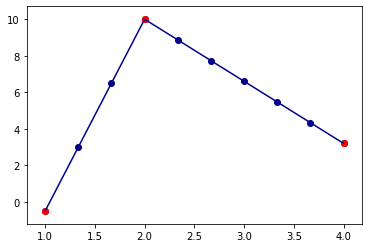

In [35]:
plt.plot(input_data_to_graph[:,0],
        model(input_data_to_graph).numpy()[0],
        color = "darkblue")
plt.scatter(input_data_to_graph[:,0],
        model(input_data_to_graph).numpy()[0],
        color = "darkblue")
plt.scatter(full_training_inputs[1:4,0],
           full_training_outputs[0][1:4],
           color = "red")
plt.show()